In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [65]:
train_data = pd.read_table('./data/zhengqi_train.txt')
test_data = pd.read_table('./data/zhengqi_test.txt')
train_data.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.015,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.183,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384


## 1. Data Explore

利用热力图来初步了解各个自变量之间的关系。

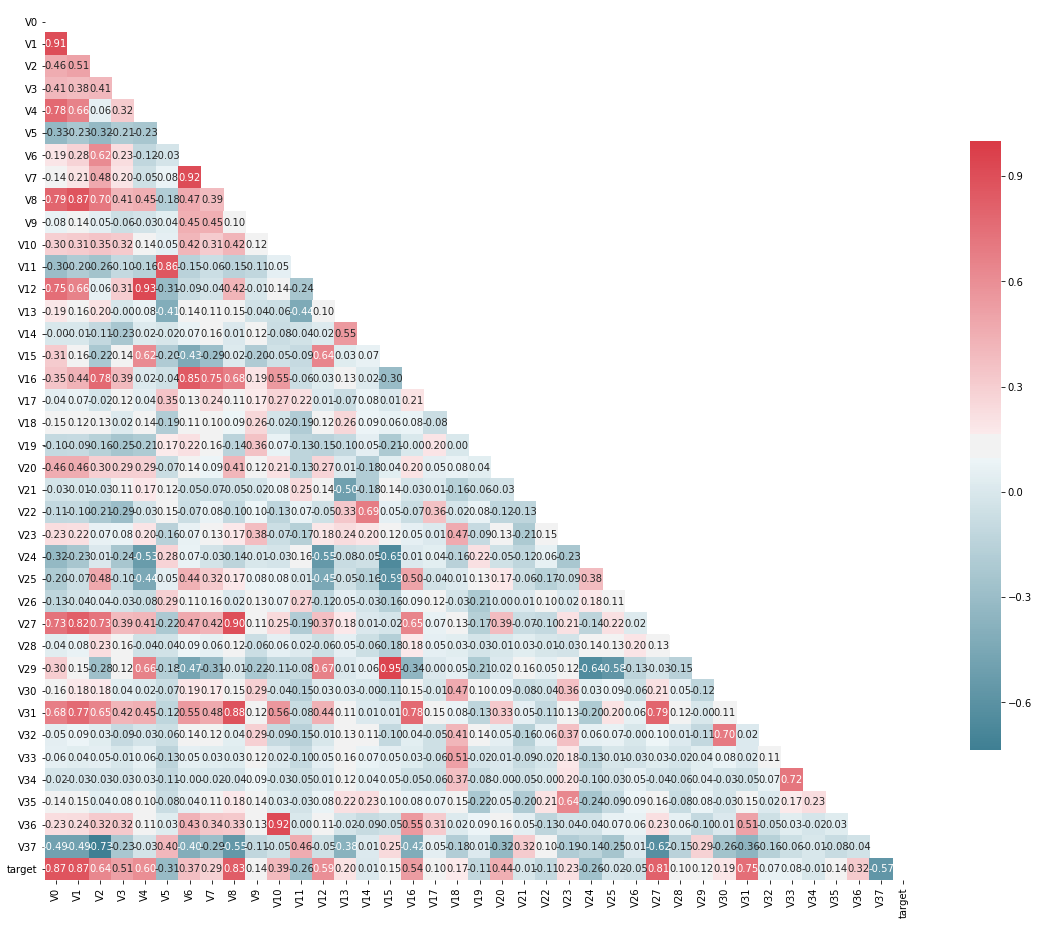

In [66]:
corr_matrix = train_data.corr()
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix, cmap=cmap, mask=mask, square=True, fmt=".2f", annot=True, cbar_kws={'shrink':.7})

对各自变量与因变量分别进行回归分析，并了解各自变量的分布情况。

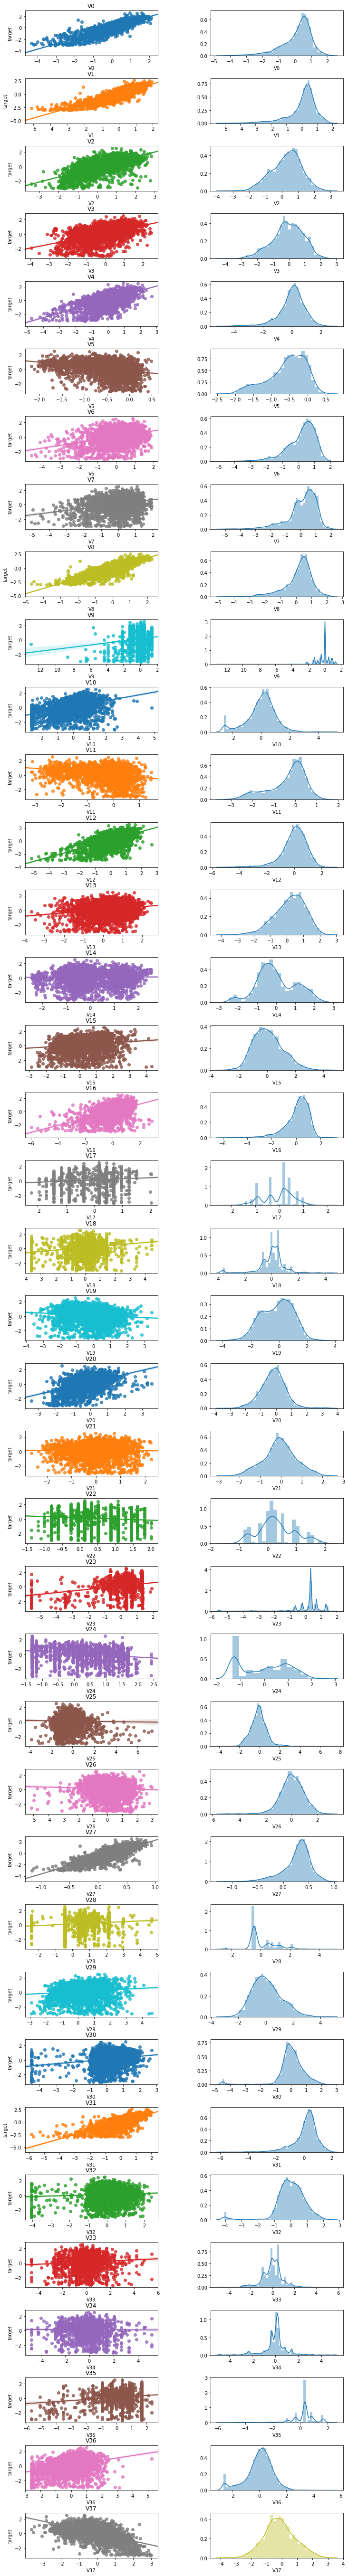

In [67]:
fig, axes = plt.subplots(nrows=38, ncols=2, figsize=(12, 2*38),squeeze=False)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
cols = train_data.drop('target', axis=1).columns
iter_row_count = 0

for col in cols:
    ax = sns.regplot(col,"target", train_data, ax=axes[iter_row_count][0])
    ax.set_title(col)
    sns.distplot(train_data[col], ax=axes[iter_row_count][1])
    iter_row_count += 1

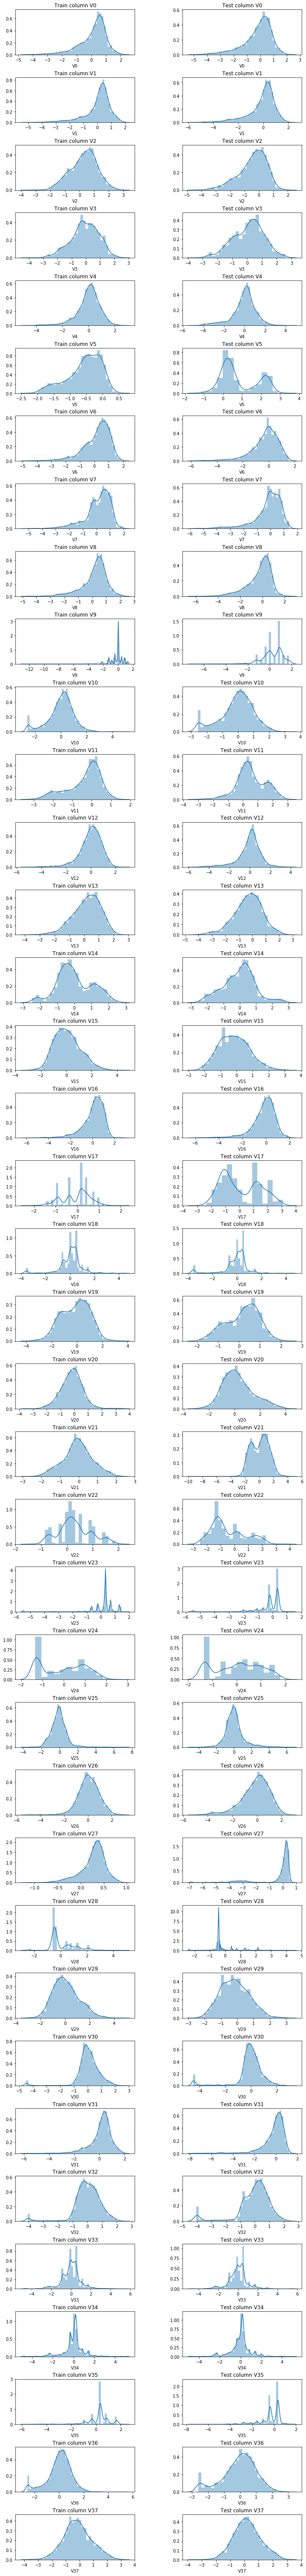

In [68]:
fig, axes = plt.subplots(nrows=38, ncols=2, figsize=(12, 2*38),squeeze=False)
plt.subplots_adjust(top = 0.99, bottom=-0.1, hspace=0.5, wspace=0.4)
cols = test_data.columns
iter_row_count = 0

for col in cols:
    ax = sns.distplot(train_data[col], ax=axes[iter_row_count][0])
    train_title = "Train column %s" % col
    ax.set_title(train_title)
    ax = sns.distplot(test_data[col], ax=axes[iter_row_count][1])
    test_title = "Test column %s" % col
    ax.set_title(test_title)
    iter_row_count += 1

## 2. 特征工程
尝试将不相关的变量排除在外进行建模。这样做法可能会误将最重要的信息排除出模型，同时排除变量总归会损失一些变量信息，该损失难以量化。

In [83]:
# 去掉训练集和测试集中与target相关系数低于0.1的列
corr_matrix = corr_matrix.abs()
drop_cols = corr_matrix['target'][corr_matrix['target']<0.1].index.tolist()

drop_cols += ['V5']  
print(drop_cols)
X_test = test_data.drop(drop_cols, axis=1)

drop_cols += ['target']  
X_train = train_data.drop(drop_cols, axis=1)
Y_train = train_data['target']

['V14', 'V21', 'V25', 'V26', 'V32', 'V33', 'V34', 'V5']


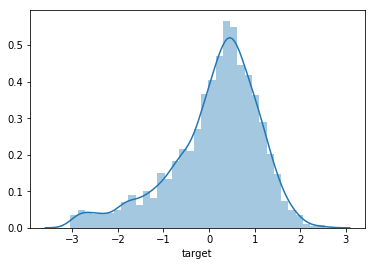

In [84]:
plt.figure()
sns.distplot(Y_train)
plt.show()

## 3. 模型搭建
利用梯度提升回归方法来建模

In [71]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [85]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=40)

GBR_pipeline = make_pipeline(StandardScaler(), 
        GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=14,
                                  max_features='sqrt', 
                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                  min_samples_leaf=10, min_samples_split=40,
                                  min_weight_fraction_leaf=0.0, n_estimators=300,
                                  random_state=10, subsample=0.8))
GBR_pipeline.fit(x_train, y_train)
y_pred = GBR_pipeline.predict(x_valid)
print("mean_squared_error:{0:.3f}, score:{1:.3f}".format(mean_squared_error(y_valid,y_pred),GBR_pipeline.score(x_valid, y_valid)))

mean_squared_error:0.099, score:0.900


In [73]:
Y_test = GBR_pipeline.predict(X_test)
np.savetxt('y_test.txt',Y_test,delimiter=',')

### 附：尝试利用网格化搜索来进行搜索最优参数

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
# 设置网格化搜索参数
model = GradientBoostingRegressor(loss='huber', max_depth=14,
                                  max_features='sqrt', 
                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                  min_samples_leaf=10, min_samples_split=40,
                                  min_weight_fraction_leaf=0.0,random_state=10, subsample=0.8)
params_grid = {
    'learning_rate':[0.01, 0.05, 0.1, 0.15],
    'n_estimators':[100, 200, 300]
}
grid_search = GridSearchCV(model, param_grid=params_grid)


In [76]:
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.845773 using {'learning_rate': 0.05, 'n_estimators': 300}


**尝试XGBRegression**

In [77]:
from xgboost import XGBRegressor

In [92]:
X_train = train_data.drop(['target','V5'], axis=1)
Y_train = train_data['target']

In [93]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=40)

Xmodel = XGBRegressor(n_estimators=100, random_state=10)
Xmodel.fit(x_train, y_train)
y_pred = Xmodel.predict(x_valid)
print("mean_squared_error:{0:.3f}, score:{1:.3f}".format(mean_squared_error(y_valid,y_pred),Xmodel.score(x_valid, y_valid)))

mean_squared_error:0.099, score:0.900


In [80]:
# 设置网格化搜索参数
model = XGBRegressor()
params_grid = {
    'learning_rate':[0.05, 0.1, 0.15],
    'n_estimators':[200, 300, 400]
}
grid_search = GridSearchCV(model, param_grid=params_grid)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.838201 using {'learning_rate': 0.05, 'n_estimators': 200}


## 随机森林

In [81]:
from sklearn.ensemble import RandomForestRegressor 

In [94]:
rfmodel = RandomForestRegressor(n_estimators= 50, max_depth=25, min_samples_split=20,
                                  min_samples_leaf=10,max_features='sqrt' ,oob_score=True, random_state=10)
rfmodel.fit(x_train, y_train)
y_pred  = rfmodel.predict(x_valid)
print("mean_squared_error:{0:.3f}, score:{1:.3f}".format(mean_squared_error(y_valid,y_pred),rfmodel.score(x_valid, y_valid)))

mean_squared_error:0.107, score:0.892
